In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit

In [23]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL

D = [
    [841,  115,   113,   54,    1,    7],   # Ramaley 1913, paper says it does not fit
    [6917, 308,   411,   53,    18,    7],  # Chamberlain 1928 
    [1842, 151,   140,   34,    5,     6],  # Rife 1940
    [140,  34,    33,    20,    8,     2],  # Merrell 1975
    [6206, 669,   471,   125,   5,     1],  # Annett 1973
    [154,  11,    31,    9,     0,     0],  # Ferronato et al. 1947
    [232,  17,    41,    7,     3,     1],  # Mascie-Taylor (unpub, in McManus 1985)
    [1060, 144,   122,   46,    3,     4],  # Chaurasia & Groswani (unpub, in McManus 1985)
    [1656, 130,   170,   40,    4,     0],  # Annett 1978
    [303,  37,    45,    15,    0,     0],  # Carter-Saltzmann 1980
    [315,  68,    57,    16,    0,     0],  # Coren & Porac 1980
    [848,  211,   325,   150,   30,   22],  # McGee & Cozad 1980
    [58,   9,     14,    5,     0,     0],  # McManus 1985 ICM1
    [134,  15,    17,    9,     1,     0],  # McManus 1985 ICM2prop
    [74,   4,     6,     2,     0,     0],  # McManus 1985 ICM2mat 
    [86,   4,     8,     1,     0,     0],  # McManus 1985 ICM2pat
    [1729, 173,   281,   63,    8,     3]   # Leiber & Axelrod 1981
]
D = np.array(D)


In [24]:
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1
    
    From Appendix 3:    
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries - 
    probability of a truly H child from a mating where parents are truly H
    """
    return np.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α) ],# RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β) ],# RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α) ] # LxL
    ])

In [25]:
def compute_t(ρ, α, β):
    """Generate t - eq .3 - the true incidence of left-handedness
    
    From main text:
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    if β == 0:        
        FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α)) # eq 3a
    else:
        Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
        FDR = (2 * α + 2 * β - 1 + np.sqrt(Δ)) / (4 * β) # eq 3    
    return 1 - FDR

In [26]:
def compute_mp_mo(D):  
    assert D.ndim == 1, D.ndim
    mp = (D[2] + D[3] + 2*D[4] + 2*D[5]) / (2*D.sum())
    mo = (D[1] + D[3] + D[5]) / D.sum()
    return mp, mo

In [27]:
def compute_P(mp, t):
    """Appendix 3"""
    if mp > t:
        u = (mp - t)/mp
        assert 0 < u < 1, u
        P = np.array([
            [1, 0 ,0],
            [u, 1-u, 0],
            [u*u, 2*u*(1-u), (1-u)*(1-u)]
        ])
    else:
        v = (t - mp)/t
        assert 0 < v < 1, (v, mp, t)
        P = np.array([
            [(1-v)*(1-v), 2*v*(1-v), v*v],
            [0, 1-v, v],
            [0, 0, 1]
        ])
    return P

In [28]:
def compute_O(mo, t):
    """Appendix 3"""
    if mo > t:
        w = (mo - t)/(1-t)
        assert 0 < w < 1, w
        O = np.array([
            [1-w, w],
            [0, 1]
        ])
    else:
        x = 1 - mo/t
        assert 0 < x < 1, x
        O = np.array([
            [1, 0], 
            [x, 1-x]
        ])
    return O

In [29]:
def compute_M(T, P, O):    
    M = P @ T @ O
    return M

In [30]:
def validate(θ):
    if len(θ)==3:
        ρ, α, β = θ
    elif len(θ)==2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))
        
    if not 0 <= ρ <= 1 or not 0 <= α <= 1 or not 0 <= β <= 1 or ρ + α > 0.5 or ρ - α > 0.5 or ρ + β > 0.5:
        return False
    return True

In [31]:
def log_likelihood(θ, D):    
    D = np.atleast_2d(D)
    if len(θ)==3:
        ρ, α, β = θ
    elif len(θ)==2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))
        
    if not validate(θ):
        return -np.inf
    S = 0
    
    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0<=T) & (T<=1)).all(), θ
    assert 0 <= t <= 1, θ
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1
        P = compute_P(mp, t)
        assert ((0<=P) & (P<=1)).all()
        O = compute_O(mo, t)
        assert ((0<=O) & (O<=1)).all()
        M = compute_M(T, P, O)
        assert ((0<=M) & (M<=1)).all()
        logM = np.log(M)
        
        S += (
            D_[0] * logM[0,0] + # R|RxR
            D_[1] * logM[0,1] + # L|RxR
            D_[2] * logM[1,0] + # R|RxL
            D_[3] * logM[1,1] + # L|RxL
            D_[4] * logM[2,0] + # R|LxL
            D_[5] * logM[2,1]   # L|LxL
        )
    return S 

In [32]:
θ_1995 = np.array([0.267, 0.148,  0.012])
# θ_1995 = np.array([0.277, 0.138])
print("Laland 1995:")
print("ρ={:.3f}, α={:.3f}, β={:.3f}, logL={:.2f}".format(*θ_1995, log_likelihood(θ_1995, D)))
# print("ρ={:.3f}, α={:.2g}, logL={:.2f}".format(*θ_1995, log_likelihood(θ_1995, D)))

Laland 1995:
ρ=0.267, α=0.148, β=0.012, logL=-9669.57


In [33]:
θ_19952d = np.array([0.277, 0.138])
print("Laland 1995 2D:")
print("ρ={:.3f}, α={:.2g}, logL={:.2f}".format(*θ_19952d, log_likelihood(θ_19952d, D)))

Laland 1995 2D:
ρ=0.277, α=0.14, logL=-9589.38


# Maximum likelihood

In [34]:
def neg_log_likelihood(θ, D):
    return -log_likelihood(θ, D)

def fit():
    θ_hat = None
    logL = -np.inf
    for _ in range(1000):
        θ0 = np.random.random(3)/3
        result = opt.minimize(neg_log_likelihood, θ0, args=(D,), method='Nelder-Mead')
        if -result.fun > logL:
            logL = -result.fun
            θ_hat = result.x
            print(θ_hat, logL, flush=True)
    return θ_hat, logL

In [35]:
θ_mle, logL = fit()

[0.22796172 0.25956622 0.03764989] -8606.689454584335


/Users/ronykarstadt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.18017648 0.31056706 0.05122723] -8606.689454456715
[0.30704682 0.16956659 0.0150378 ] -8604.364820534036
[0.31597119 0.16067648 0.00520691] -8604.30179095197
[3.20605265e-01 1.56064666e-01 1.01033520e-05] -8604.286610925452
[3.20703437e-01 1.55960349e-01 8.17214432e-07] -8604.286584525733
[3.20654337e-01 1.56013473e-01 5.45368863e-06] -8604.286577693862


In [36]:
print("MLE estimate, logL={:.2f}".format(log_likelihood(θ_mle, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_mle))

MLE estimate, logL=-8604.29
ρ=0.321, α=0.156, β=0.000


## Grid MLE

In [37]:
from concurrent.futures import ThreadPoolExecutor

In [38]:
pts = 50
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)
θs = np.array([ρs, αs, βs])
grid = np.meshgrid(ρs, αs, βs)

In [39]:
logL = np.zeros((pts, pts, pts))
futs = logL.tolist()

In [40]:
with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs[i][j][k] = pool.submit(log_likelihood, θ_, D)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [41]:
for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs[i][j][k].exception(): 
                print("Problem with", ρ_, α_, β_, ":", futs[i][j][k].exception())
                logL[i,j,k] = -np.inf
            else: logL[i,j,k] = futs[i][j][k].result()

Problem with 0.24489795918367346 0.16326530612244897 0.0 : 0.0


In [42]:
logL.max()

-8606.712056612818

In [43]:
i,j,k = (logL == logL.max()).nonzero()
θ_grid = ρs[i][0], αs[j][0], βs[k][0]

print("Grid MLE estimate, logL={:.2f}".format(log_likelihood(θ_grid, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid))

Grid MLE estimate, logL=-8606.71
ρ=0.184, α=0.306, β=0.061


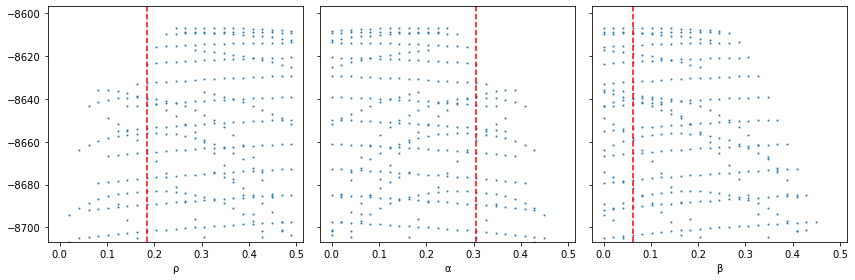

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
#     ax.axvline(θ_mle[i], color='g')
#     ax.axvline(θ_1995[i], color='k')
#     ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylim(logL.max()-100, logL.max()+10)

fig.tight_layout()

# Bayesian inference

In [45]:
import emcee
import corner

In [46]:
def log_prior(θ):
    if (θ < 0).any() or (θ>1).any():
        return -np.inf
    ρ, α, β = θ
    T = compute_T(ρ, α, β)
    if not ((0<=T) & (T<=1)).all():
        return -np.inf
    t = compute_t(ρ, α, β)
    if t < 0 or t > 1:
        return -np.inf
    return 0

log_prior(θ_1995)

0

In [47]:
def log_posterior(θ, D):
    logpri = log_prior(θ)
    if np.isinf(logpri):
        return logpri
    return logpri + log_likelihood(θ, D)

log_posterior(θ_1995, D)

-9669.572842560992

### 3D

In [48]:
filename = "Laland1995_3d.h5"
ndim = 3  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

In [49]:
guesses = abs(np.random.normal(θ_1995, 0.01, size=(nwalkers, ndim)))
assert np.isfinite([log_prior(g) for g in guesses]).all()
assert np.isfinite([log_posterior(g, D) for g in guesses]).all()

In [50]:
# Set up the backend
# Don't forget to clear it in case the file already exists
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [51]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[D],
    backend=backend
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
);

In [52]:
reader = emcee.backends.HDFBackend(filename, read_only=True)

In [53]:
chain = reader.get_chain(discard=nsteps//2)
chain.mean(axis=(0,1))
# 0.13374314, 0.33377329, 0.12063704

array([0.18269886, 0.29768249, 0.0774601 ])

In [54]:
idxmax = sampler.flatlnprobability.argmax()
θ_map = sampler.flatchain[idxmax, :]

In [55]:
print("MAP estimate, logL={:.2f}".format(log_likelihood(θ_map, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_map))

MAP estimate, logL=-8604.29
ρ=0.318, α=0.158, β=0.002


In [56]:
print("Laland 1995, logL={:.2f}".format(log_likelihood(θ_1995, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_1995))

Laland 1995, logL=-9669.57
ρ=0.267, α=0.148, β=0.012


In [57]:
idx = sampler.lnprobability > log_likelihood(θ_map, D) * 1.01
idx.shape, idx.mean()

((10, 100000), 0.874212)

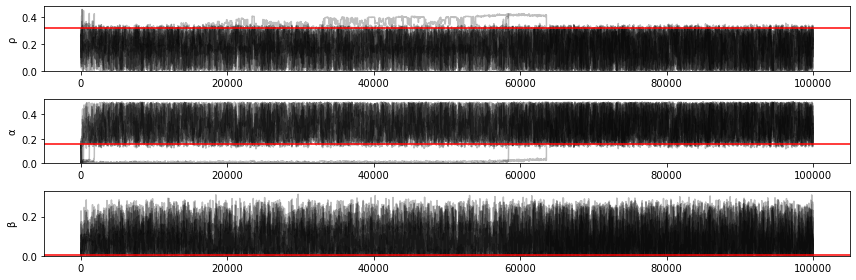

In [58]:
fig, axes = plt.subplots(ndim, 1, figsize=(12, 4))
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25)
    ax.axhline(θ_map[i], color='r')
    ax.set_ylabel(labels[i])
    ax.set_ylim(0, None)
fig.tight_layout()

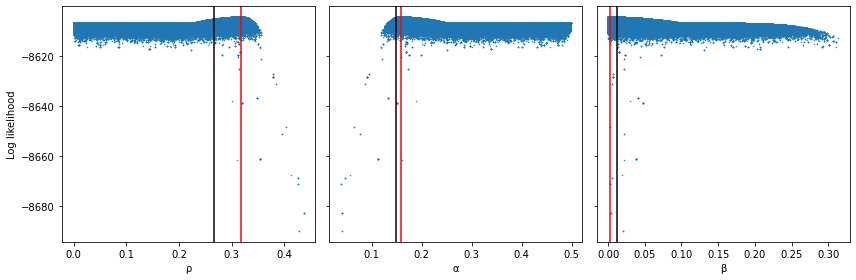

In [59]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
#     ax.axvline(θ_mle[i], color='g')
    ax.axvline(θ_1995[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
fig.tight_layout()

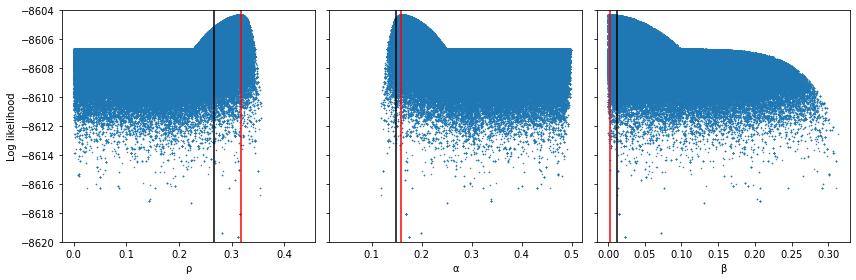

In [60]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
#     ax.axvline(θ_mle[i], color='g')
    ax.axvline(θ_1995[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
axes[0].set_ylim(-8620, -8604)
fig.tight_layout()

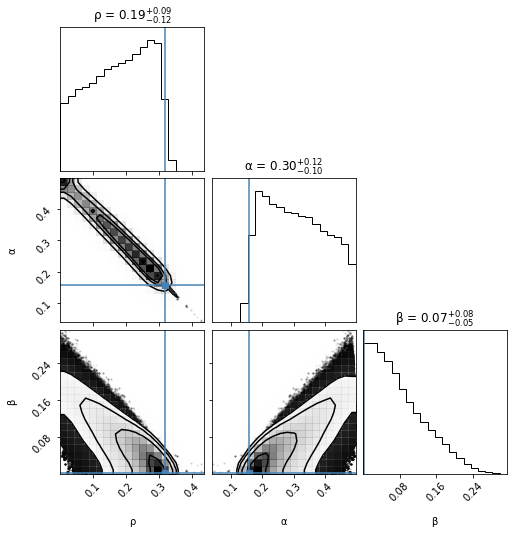

In [61]:
cor = corner.corner(
    sampler.flatchain[idx], 
    smooth=True,
    labels=labels,
    show_titles=True,
    truths=θ_map
)

### 2D

In [62]:
def log_prior(θ):
    if (θ < 0).any() or (θ>1).any():
        return -np.inf
    ρ, α = θ
    β = 0
    T = compute_T(ρ, α, β)
    if not ((0<=T) & (T<=1)).all():
        return -np.inf
    t = compute_t(ρ, α, β)
    if t < 0 or t > 1:
        return -np.inf
    return 0

In [63]:
ndim = 2  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

guesses = abs(np.random.normal(θ_1995[:2], 0.01, size=(nwalkers, ndim)))
assert np.isfinite([log_prior(g) for g in guesses]).all()
assert np.isfinite([log_posterior(g, D) for g in guesses]).all()

In [64]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "Laland1995_2d.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [66]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[D],
    backend=backend
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
);

In [67]:
idxmax = sampler.flatlnprobability.argmax()
θ_map = sampler.flatchain[idxmax, :]

In [68]:
print("MAP estimate, logL={:.2f}".format(log_likelihood(θ_map, D)))
print("ρ={:.3f}, α={:.3f}".format(*θ_map))

MAP estimate, logL=-8604.29
ρ=0.321, α=0.156


In [69]:
idx = sampler.lnprobability > log_likelihood(θ_map, D) * 1.01
idx.shape, idx.mean()

((10, 140210), 0.8982347906711362)

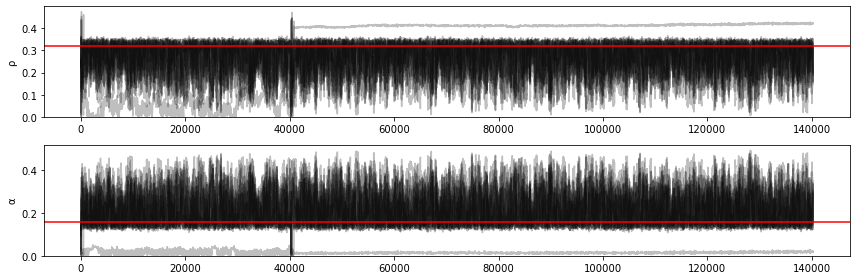

In [70]:
fig, axes = plt.subplots(ndim, 1, figsize=(12, 4))
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25)
    ax.axhline(θ_map[i], color='r')
    ax.set_ylabel(labels[i])
    ax.set_ylim(0, None)
fig.tight_layout()

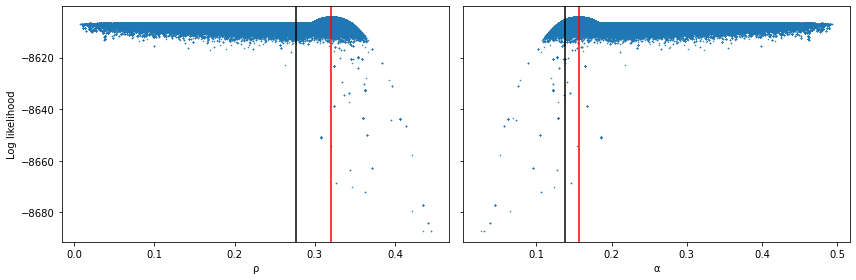

In [71]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
fig.tight_layout()

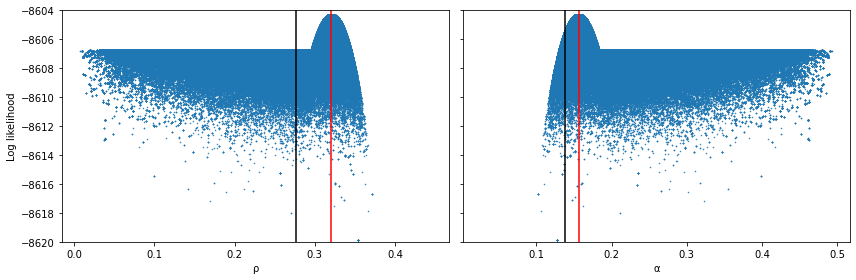

In [72]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
axes[0].set_ylim(-8620, -8604)
fig.tight_layout()

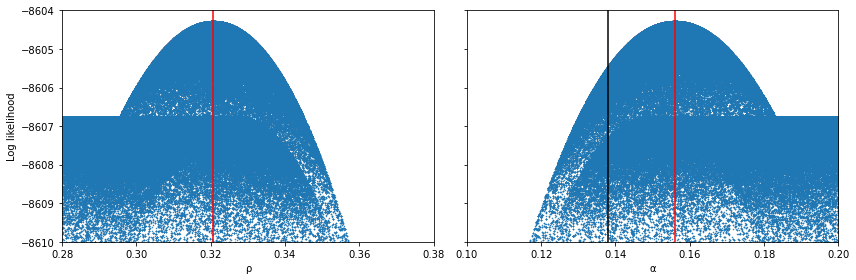

In [73]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
axes[0].set_ylim(-8610, -8604)
axes[0].set_xlim(0.28, 0.38)
axes[1].set_xlim(0.1, 0.2)
fig.tight_layout()

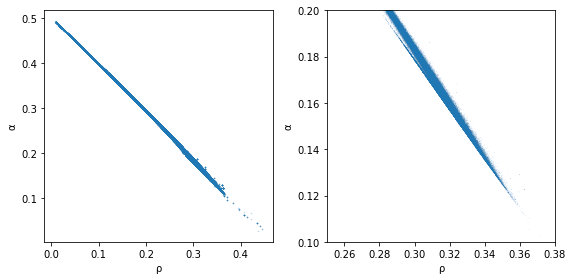

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax = axes[0]
ax.plot(samples[:, 0], samples[:, 1], '.', markersize=1, alpha=0.3)
ax.set_xlabel('ρ')
ax.set_ylabel('α')

ax = axes[1]
ax.plot(samples[:, 0], samples[:, 1], ',', alpha=0.01)
ax.set_xlabel('ρ')
ax.set_ylabel('α')
ax.set(xlim=(0.25, 0.38), ylim=(0.1, 0.2));

fig.tight_layout()

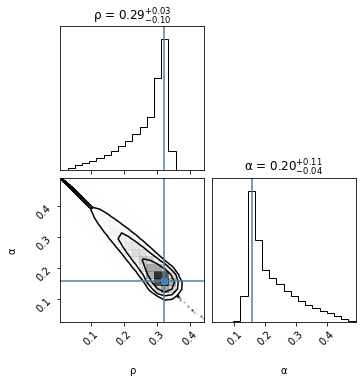

In [75]:
cor = corner.corner(
    sampler.flatchain[idx], 
    smooth=True,
    labels=labels,
    show_titles=True,
    truths=θ_map
)